<a href="https://colab.research.google.com/github/Crepopcorn/cat-vs-dog-vit-project/blob/main/large_main_dog_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from functools import partial
from collections import OrderedDict

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import os
import matplotlib.pyplot as plt
import time

from torch.autograd import Variable

%matplotlib inline


In [6]:
from google.colab import drive
drive.mount("/content/drive/")

data_dir = '/content/drive/My Drive/data'

data_tansform = { x:transforms.Compose([transforms.Resize([224,224]),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])])
                                       for x in ["train","val"]}
image_datasets = {x:datasets.ImageFolder(root=os.path.join(data_dir,x),
                                        transform = data_tansform[x])
                                         for x in ["train","val"]}
dataloader = {x:torch.utils.data.DataLoader(dataset=image_datasets[x],
                                           batch_size=16,
                                           shuffle=True)
              for x in ["train","val"]}




Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog']


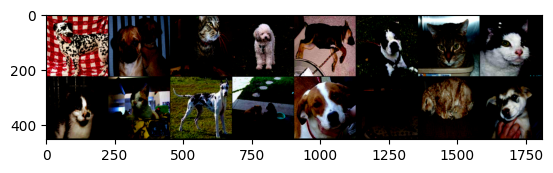

In [7]:
x_example,y_example = next(iter(dataloader["train"]))
example_clasees = image_datasets["train"].classes

index_classes = image_datasets["train"].class_to_idx

img = torchvision.utils.make_grid(x_example)
img = img.numpy().transpose([1,2,0])
print([example_clasees[i] for i in y_example])
plt.imshow(img)
plt.show()


In [8]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


In [9]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=1024, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."

        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x

In [10]:
class Attention(nn.Module):
    def __init__(self,
                 dim,
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):

        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)

        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [11]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [12]:
class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)

        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [13]:
def _init_vit_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, std=.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, num_classes=1000,
                 embed_dim=1024, depth=24, num_heads=24, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):

        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ("fc", nn.Linear(embed_dim, representation_size)),
                ("act", nn.Tanh())
            ]))
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        # Weight init
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        if self.dist_token is not None:
            nn.init.trunc_normal_(self.dist_token, std=0.02)

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(_init_vit_weights)

    def forward_features(self, x):

        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training and not torch.jit.is_scripting():

                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def vit_cat_vs_dog(num_classes: int = 2):

    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=192,
                              depth=3,
                              num_heads=4,
                              representation_size=None,
                              num_classes=num_classes)
    return model
model = vit_cat_vs_dog().to(device)


In [16]:
loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=.00001)

epoch_n = 15
time_open = time.time()

accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

for epoch in range(epoch_n):
    print("Epoch{}/{}".format(epoch,epoch_n-1))
    print("-"*10)

    for phase in ["train","val"]:
        if phase == "train":
            print("Training...")
            model.train(True)
        else:
            print("Validing...")
            model.train(False)

        running_loss = .0
        running_corrects = 0

        for batch,data in enumerate(dataloader[phase],1):
            x,y=data
            x,y = Variable(x.to(device)),Variable(y.to(device))
            y_pred = model(x)

            _,pred = torch.max(y_pred.data,1)

            optimizer.zero_grad()

            loss = loss_f(y_pred,y)

            if phase == "train":
                loss.backward()
                optimizer.step()

            running_loss += loss.data.item()
            running_corrects += torch.sum(pred==y.data)

            if batch%500 == 0 and phase == "train":
                print("Batch{},Train Loss:{:.4f},Train ACC:{:.4f}".format(batch,running_loss/batch,100*running_corrects/(16*batch)))

        epoch_loss = running_loss*16/len(image_datasets[phase])
        epoch_acc = 100*running_corrects/len(image_datasets[phase])

        if phase == "train":
          accuracy.append(float(epoch_acc))
          train_loss.append(float(epoch_loss))
        else:
          val_accuracy.append(float(epoch_acc))
          val_loss.append(float(epoch_loss))

        print("{} Loss:{:.4f} Acc:{:.4f}%".format(phase,epoch_loss,epoch_acc))

time_end = time.time() - time_open
print(time_end)

Epoch0/14
----------
Training...
Batch500,Train Loss:0.6533,Train ACC:59.7750
Batch1000,Train Loss:0.6499,Train ACC:59.9750
train Loss:0.6492 Acc:60.2300%
Validing...
val Loss:0.6367 Acc:62.8200%
Epoch1/14
----------
Training...
Batch500,Train Loss:0.6391,Train ACC:61.7875
Batch1000,Train Loss:0.6386,Train ACC:61.5500
train Loss:0.6358 Acc:61.9700%
Validing...
val Loss:0.6365 Acc:62.7200%
Epoch2/14
----------
Training...
Batch500,Train Loss:0.6244,Train ACC:63.7375
Batch1000,Train Loss:0.6225,Train ACC:64.0500
train Loss:0.6225 Acc:63.9750%
Validing...
val Loss:0.6129 Acc:64.7600%
Epoch3/14
----------
Training...
Batch500,Train Loss:0.6164,Train ACC:64.8000
Batch1000,Train Loss:0.6122,Train ACC:64.9438
train Loss:0.6088 Acc:65.2900%
Validing...
val Loss:0.6101 Acc:66.7000%
Epoch4/14
----------
Training...
Batch500,Train Loss:0.5981,Train ACC:66.5500
Batch1000,Train Loss:0.5958,Train ACC:66.9563
train Loss:0.5961 Acc:66.9550%
Validing...
val Loss:0.6014 Acc:66.9200%
Epoch5/14
----------

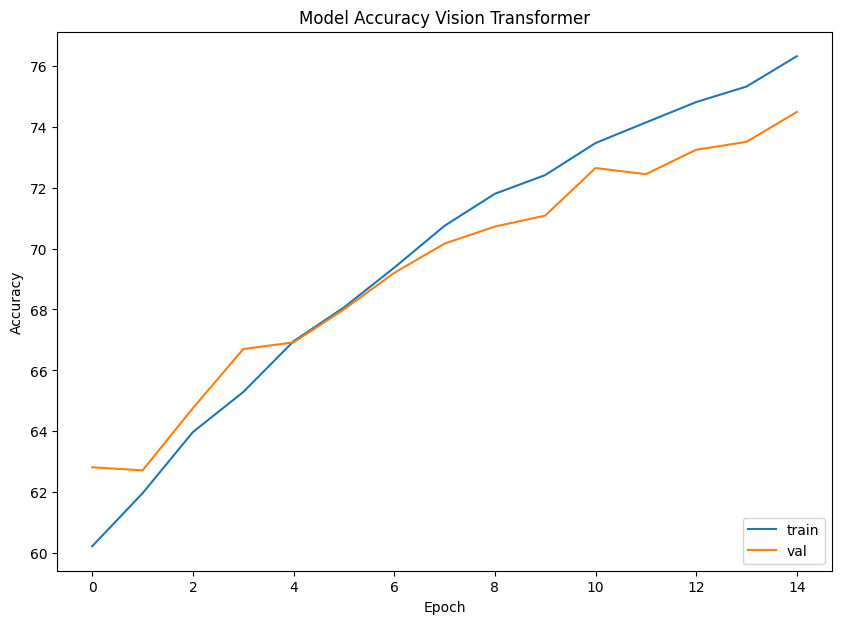

In [17]:
plt.figure(figsize=(10,7))
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model Accuracy Vision Transformer')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

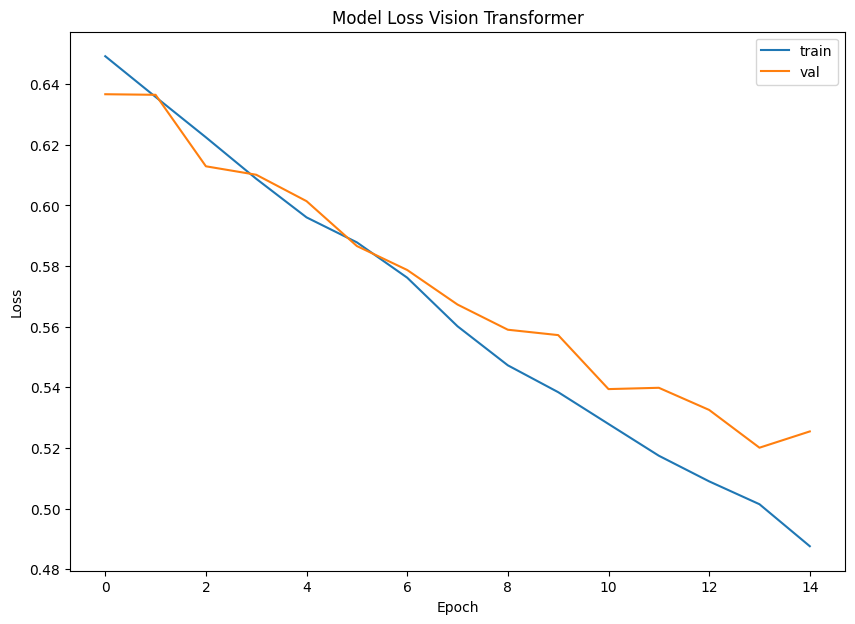

In [18]:
plt.figure(figsize=(10,7))
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss Vision Transformer')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [19]:
model_save_name = 'large_main_dog_cat_classifier.pt'
path = F"/content/drive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)